In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns

import openeo
#import ee
# Trigger the authentication flow.
#ee.Authenticate()
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def make_input_array(self):
        ## Puts pandas phenological frame into driver xarray and aligns the two
        just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
        x_coords = just_emergence_phen_data['lon'].values
        y_coords = just_emergence_phen_data['lat'].values
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_coords, y_coords)
        print('interpolate driver to station locations')
        # Working in xarray (not pandas) after this point:
        self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
        self.GDD_driver_data['Stations_id'] = (("modelpoint"), np.int64(just_emergence_phen_data['Stations_id'].values))
        self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), np.int64(just_emergence_phen_data['Referenzjahr'].values))
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
        ## Get times to be indexed from emergence day start at emergence day for every site ##
        self.index_time_from_emergence_day()
        self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        if type(self.GDD_driver_data) == str:
            print('Make a dataset for the driving variable first')
        else:
            t_dev = np.zeros(self.GDD_driver_data[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
            dev_time_series = [t_dev.copy()]
            for day in range(365):
                driver_values = self.GDD_driver_data.isel(time=day)[driver_variable].values 
                t_dev += response(driver_values, t_dev)
                dev_time_series.append(t_dev.copy())
            self.model_dev_time_series = np.array(dev_time_series)
            self.GDD_driver_data['Development Time'] = (('days from emergence', 'modelpoint'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    
    def get_modelled_dataset(self, phase_list = []):
        if len(phase_list) == 0:
            computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
        else:
            computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
            #Initialize dataset for comparison with station IDs and years
        data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                        }
        self.ds_comparison = pd.DataFrame(data_comparison)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(computed_phases):
            self.ds_comparison[phase] = self.phase_dates_array[phase_index, :]
        self.ds_comparison.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, phase_list, winter_sowing = False):
        observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase_list[0], winter_sowing=winter_sowing).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
        for phase in phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
        self.ds_observed = self.ds_observed.reset_index()
        self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.concat([self.ds_comparison, self.ds_observed], axis = 1)

    ## Functions for ML ##    
    def put_obs_data_in_input_array(self): #, predictor_days = 200
        y_data = {}
        for phase_time in self.ds_observed.columns:
            if phase_time != 'lat' and phase_time != 'lon':
                y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
        #print(y_data)
        obs_data = xr.Dataset(data_vars = y_data,
                                coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                        'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                        )
        #print(obs_data)
        obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
        #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
        #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
        self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
        self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')
        
    def get_X_y_for_ML(self, driver_variable, predictor_days = 200):
        self.X_for_ML = self.GDD_driver_data[driver_variable][:, :predictor_days].values.T
        self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns])[:, :predictor_days].T
    
    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, phase_list, md=20):
        regr = tree.DecisionTreeRegressor(max_depth=md)
        fit = regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results.drop_duplicates(), self.ds_comparison, self.ds_observed], axis = 1)


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_28236\2446806561.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [3]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()


project to new coords
interpolate driver to station locations


USE THIS FOR LOOKING AT WHERE ALL THE WHEAT IS
 - https://atlas.thuenen.de/webspace/agraratlas/agraratlas/index.html?LP=1

In [16]:
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]#0.0254, 0.0289
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.get_modelled_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas')
Maize_set.subsample_X_y()
Maize_set.decision_tree(['beginning of flowering', 'yellow ripeness'])
Maize_set.ML_modelled_observed()

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


In [10]:
Maize_set.ds_ML_modelled_observed

Training  \
Referenzjahr Stations_id            
2007         7504           False   
2008         7504           False   
2009         7504           False   
2010         7504           False   
2015         7521           False   
...                           ...   
2022         19296            NaN   
             19438            NaN   
             19483            NaN   
             19587            NaN   
             19914            NaN   

                          ML prediction emergence to beginning of flowering  \
Referenzjahr Stations_id                                                      
2007         7504                                                      76.0   
2008         7504                                                      75.0   
2009         7504                                                      90.0   
2010         7504                                                      81.0   
2015         7521                                                      79.0   
...                                                                     ...   
2022         19296                                                      NaN   
             19438                                                      NaN   
             19483                                                      NaN   
             19587                                                      NaN   
             19914                                                      NaN   

                          ML check obs to beginning of flowering  \
Referenzjahr Stations_id                                           
2007         7504                                           80.0   
2008         7504                                           77.0   
2009         7504                                           83.0   
2010         7504                                           71.0   
2015         7521                                           76.0   
...                                                          ...   
2022         19296                                           NaN   
             19438                                           NaN   
             19483                                           NaN   
             19587                                           NaN   
             19914                                           NaN   

                          ML prediction emergence to yellow ripeness  \
Referenzjahr Stations_id                                               
2007         7504                                              152.0   
2008         7504                                              125.0   
2009         7504                                              134.0   
2010         7504                                              124.0   
2015         7521                                              129.0   
...                                                              ...   
2022         19296                                               NaN   
             19438                                               NaN   
             19483                                               NaN   
             19587                                               NaN   
             19914                                               NaN   

                          ML check obs to yellow ripeness  \
Referenzjahr Stations_id                                    
2007         7504                                   145.0   
2008         7504                                   147.0   
2009         7504                                   126.0   
2010         7504                                   140.0   
2015         7521                                   143.0   
...                                                   ...   
2022         19296                                    NaN   
             19438                                    NaN   
             19483                                    NaN   
             19587    

In [36]:
Maize_set.ds_observed.xs(19732, level=1, drop_level=False)#[:, 19732]#19914]
#Maize_set.ds_observed.xs(1957, level=0, drop_level=False)

NameError: name 'Maize_set' is not defined

In [6]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

In [40]:
# Connect to openEO back-end.
connection = openeo.connect("openeo.dataspace.copernicus.eu/openeo/1.2").authenticate_oidc()

Authenticated using refresh token.


In [41]:
Maize_set.ds_ML_modelled_observed[['lat', 'lon']].values.tolist()[:100][2]

[54.3167, 10.05]

In [42]:
locs_for_datacube =   { "type": "FeatureCollection",
    "features": []
}
for coords in Maize_set.ds_ML_modelled_observed[['lat', 'lon']].values.tolist()[:100]:
    locs_for_datacube["features"].append({"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": coords}})

In [43]:
datacube = connection.load_collection(
  "SENTINEL2_L2A",
  spatial_extent={"west": 5, "south": 47, "east": 16, "north": 56},
  temporal_extent=["2016-01-01", "2016-01-31"],
  bands=["B04", "B08"]
)

In [44]:
locationed = datacube.aggregate_spatial(geometries = locs_for_datacube, reducer = 'mean')

In [45]:
res = locationed.save_result(format = "NetCDF")

In [37]:
print([dataset_info['summary'] for dataset_info in connection.list_processes()[123:]])
print(connection.list_processes()[123])

['One-dimensional linear interpolation for arrays', 'Manipulates dates and times by addition or subtraction', 'Between comparison for dates and times', 'Merge two arrays', 'Create an array', 'Add information to the logs', 'Text begins with another text', 'Text contains another text', 'Text ends with another text', 'Concatenate elements to a single text', 'Loads data from STAC', 'If-Then-Else conditional', 'Export data to a cloud user workspace', 'Normalized difference']
{'categories': ['arrays', 'math', 'math > interpolation'], 'description': 'Performs a linear interpolation for each of the no-data values (`null`) in the array given, except for leading and trailing no-data values.\n\nThe linear interpolants are defined by the array indices or labels (x) and the values in the array (y).', 'examples': [{'arguments': {'data': [None, 1, None, 6, None, -8]}, 'returns': [None, 1, 3.5, 6, -1, -8]}, {'arguments': {'data': [None, 1, None, None]}, 'returns': [None, 1, None, None]}], 'id': 'array

In [46]:
job = res.execute_batch(title="Sentinel2_practise")

0:00:00 Job 'j-241204314c5249f787a6f59121c5a55f': send 'start'
0:00:14 Job 'j-241204314c5249f787a6f59121c5a55f': created (progress 0%)
0:00:19 Job 'j-241204314c5249f787a6f59121c5a55f': created (progress 0%)
0:00:25 Job 'j-241204314c5249f787a6f59121c5a55f': created (progress 0%)
0:00:33 Job 'j-241204314c5249f787a6f59121c5a55f': created (progress 0%)
0:00:44 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:00:56 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:01:12 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:01:31 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:01:55 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:02:25 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:03:02 Job 'j-241204314c5249f787a6f59121c5a55f': running (progress N/A)
0:03:49 Job 'j-241204314c5249f787a6f59121c5a55f': finished (progress 100%)


In [47]:
job.get_results().download_files("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd")

[WindowsPath('C:/Users/wlwc1989/Documents/Phenology_Test_Notebooks/phenology_dwd/timeseries.nc'),
 WindowsPath('C:/Users/wlwc1989/Documents/Phenology_Test_Notebooks/phenology_dwd/job-results.json')]

In [48]:
Sat_Vars = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\timeseries.nc')

In [50]:
Sat_Vars['B04'].values

array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [ 193.,  390.,  184.],
       [ 952.,  185.,  243.],
       [ 952.,  185.,  243.],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  

In [19]:
def get_images_after_emergence(Img_Collection, emergence_date, length_of_period = 300):
    end_date = emergence_date + np.timedelta64(length_of_period, 'D')
    Img_Collection = Img_Collection.filterDate(emergence_date, end_date)
    return Img_Collection

In [22]:
S2 = get_images_after_emergence(S2, Maize_set.GDD_driver_data['time'][0][0].values).select('B4', 'B8', 'QA60')

In [23]:
S2.get()

In [10]:
Maize_set.GDD_driver_data['time'][0][0].values

numpy.datetime64('2007-05-02T12:00:00.000000000')

In [36]:
Maize_set.GDD_driver_data

<xarray.Dataset>
Dimensions:                                            (modelpoint: 7956,
                                                        time: 366,
                                                        days from emergence: 366)
Coordinates:
  * modelpoint                                         (modelpoint) object MultiIndex
  * Referenzjahr                                       (modelpoint) int64 200...
  * Stations_id                                        (modelpoint) int64 750...
    time                                               (time, modelpoint) datetime64[ns] ...
    lon                                                (modelpoint) float64 1...
    lat                                                (modelpoint) float64 5...
    x                                                  (modelpoint) float64 4...
    y                                                  (modelpoint) float64 3...
Dimensions without coordinates: days from emergence
Data variables:
    crs_HYRAS                                          int32 1
    tas                                                (time, modelpoint) float64 ...
    number_of_stations                                 (time, modelpoint) float64 ...
    emergence_dates                                    (modelpoint) datetime64[ns] ...
    Development Time                                   (days from emergence, modelpoint) float64 ...
    observed time emergence to beginning of flowering  (modelpoint) float64 8...
    observed time emergence to yellow ripeness         (modelpoint) float64 1...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [18]:
driver2007 = Maize_set.GDD_driver_data.where((Maize_set.GDD_driver_data['Referenzjahr'] == 2007)*(Maize_set.GDD_driver_data['Stations_id'] == 19732), drop=True)['Development Time']

(0.0, 120.0)

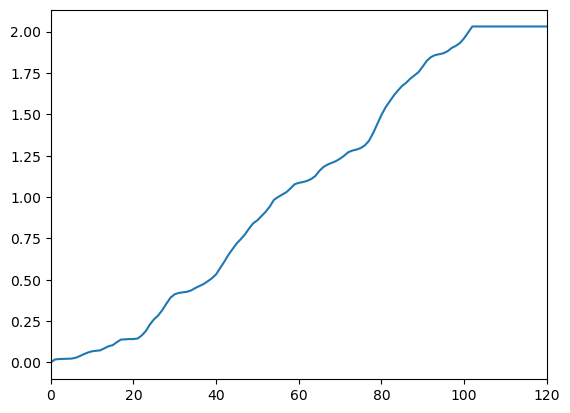

In [20]:
plt.plot(driver2007)
plt.xlim((0, 120))

In [8]:
Maize_set.ds_observed

observed time emergence to beginning of flowering  \
Referenzjahr Stations_id                                                      
1951         7617                                                      29.0   
             7899                                                      80.0   
             8137                                                      50.0   
             8191                                                      54.0   
             8234                                                      98.0   
...                                                                     ...   
2022         19488                                                     63.0   
             19554                                                     83.0   
             19585                                                     70.0   
             19587                                                     60.0   
             19914                                                     57.0   

                          observed time emergence to yellow ripeness      lat  \
Referenzjahr Stations_id                                                        
1951         7617                                                NaN  54.6167   
             7899                                                NaN  52.0833   
             8137                                                NaN  52.8667   
             8191                                                NaN  53.2667   
             8234                                                NaN  52.9333   
...                                                              ...      ...   
2022         19488                                             129.0  48.4024   
             19554                                             105.0  53.3222   
             19585                                             128.0  53.6865   
             19587                                               NaN  48.7091   
             19914                                               NaN  50.3168   

                              lon  
Referenzjahr Stations_id           
1951         7617          9.0333  
             7899          9.5667  
             8137          9.6000  
             8191         10.1167  
             8234         11.1167  
...                           ...  
2022         19488        11.6946  
             19554        11.9321  
             19585        11.0608  
             19587         9.2147  
             19914         9.3627  

[27886 rows x 4 columns]

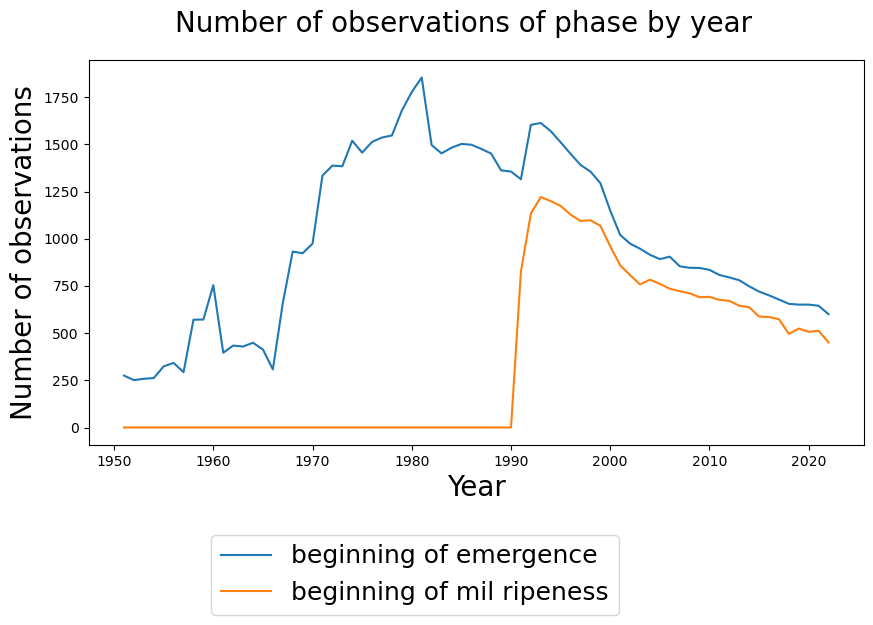

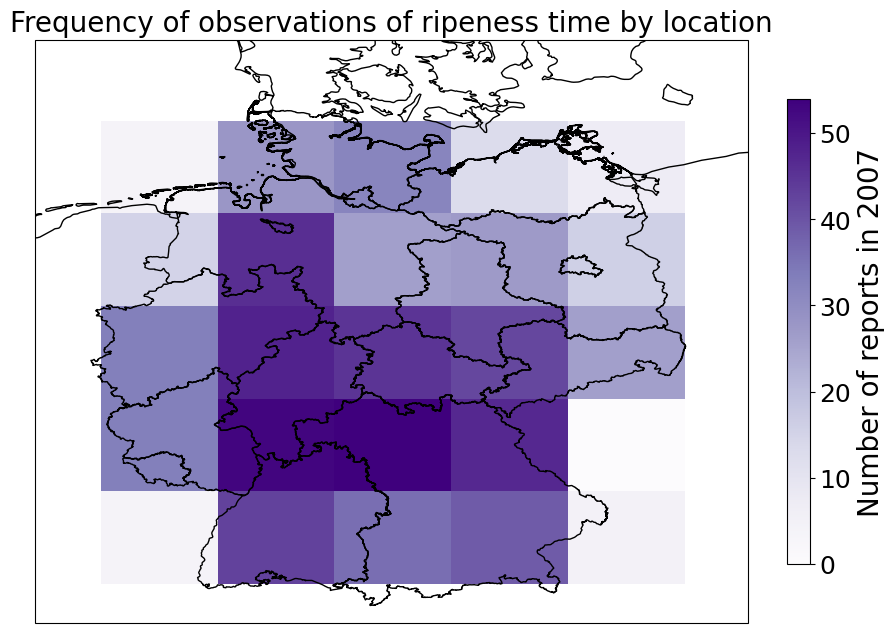

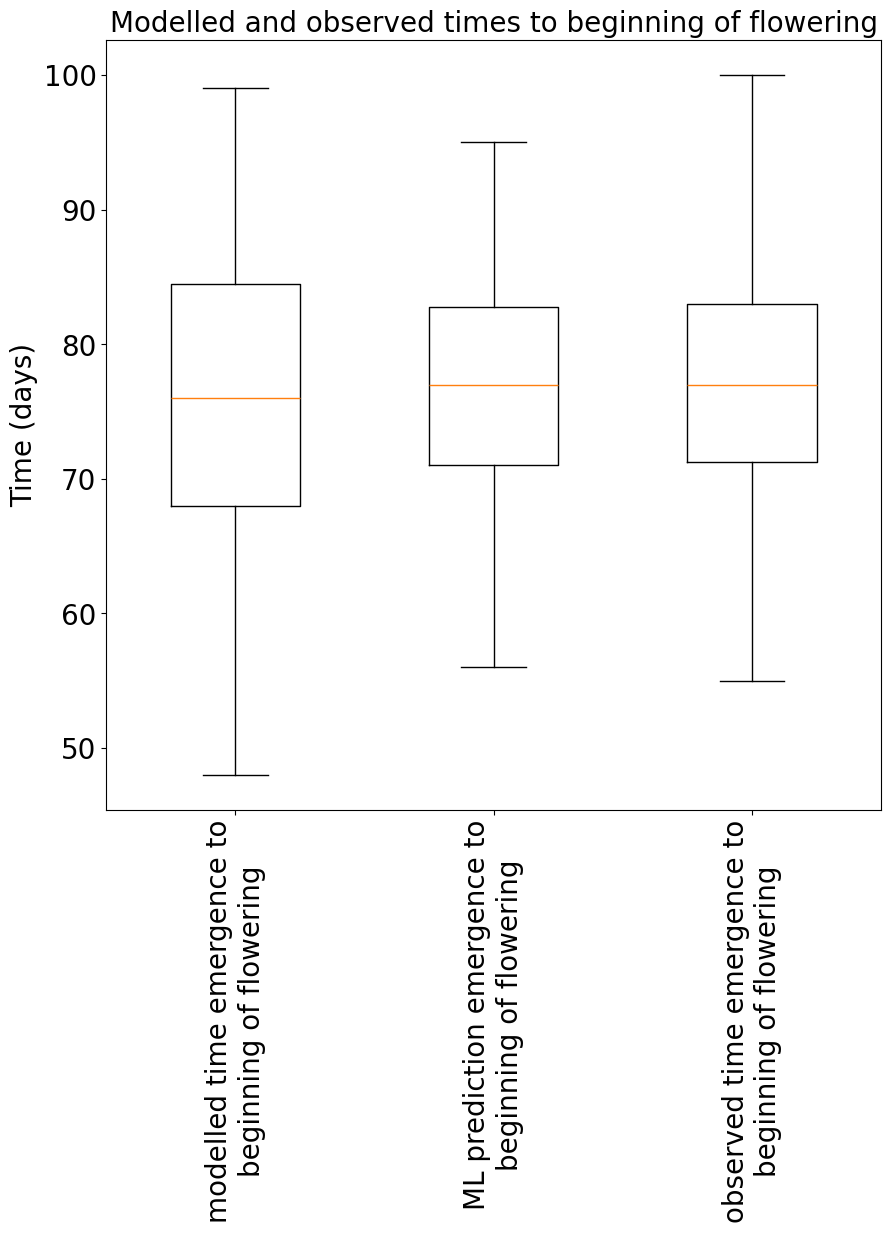

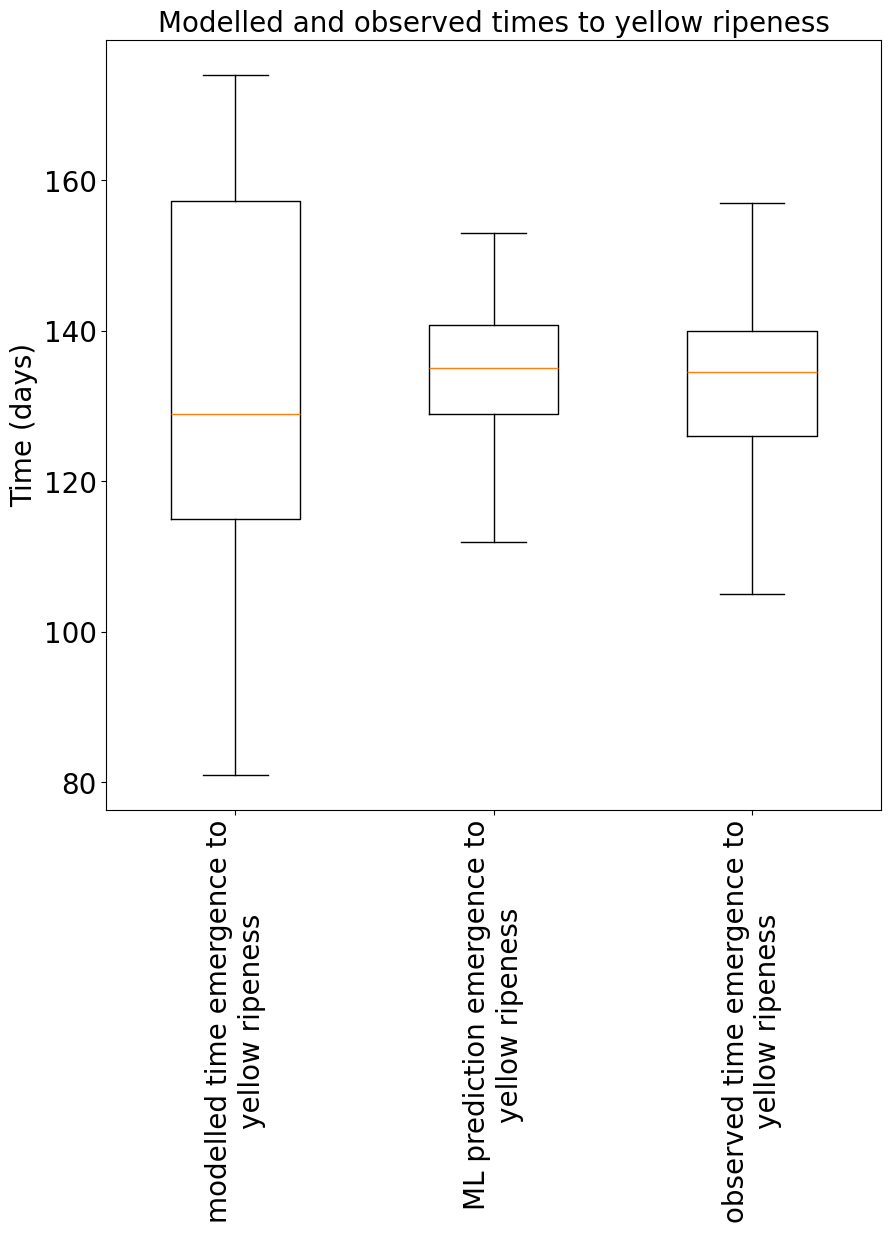

In [17]:
phase_list = ['beginning of emergence', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2007].dropna()['lat'], Maize_set.ds_observed.loc[2007].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
def get_ML_dataset(self, phase_list = []):
    if len(phase_list) == 0:
        computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
    else:
        computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
        #Initialize dataset for comparison with station IDs and years
    data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                    'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                    }
    self.ds_comparison = pd.DataFrame(data_comparison)
    #Add modelled phase dates etc. to the comparison set.
    ML_e
    for phase_index, phase in enumerate(computed_phases):
        self.ds_comparison[phase] = self.ML_fit[phase_index, :]
    self.ds_comparison.set_index(['Referenzjahr', 'Stations_id'], inplace=True)

In [41]:
## Check that indexing is right
S = 7504
Y = 2005
print(ds['tas'].sel(Referenzjahr=Y, Stations_id = S).values, Maize_set.GDD_driver_data['tas'].sel(Referenzjahr=Y, Stations_id = S).values)
print(ds.sel(Referenzjahr=Y, Stations_id = S)['observed time emergence to beginning of flowering'].values, Maize_set.ds_observed.loc[(S, Y)]['observed time emergence to beginning of flowering'])

[-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684] [-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684]
100.0 100.0
